Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0
Training : [1,  1250] loss: 1.066 accuracy: 0.650
Validation : [1,   157] loss: 0.593 accuracy: 0.679
Training : [2,  1250] loss: 0.497 accuracy: 0.834
Validation : [2,   157] loss: 0.483 accuracy: 0.835
Training : [3,  1250] loss: 0.343 accuracy: 0.886
Validation : [3,   157] loss: 0.424 accuracy: 0.881
Training : [4,  1250] loss: 0.241 accuracy: 0.921
Validation : [4,   157] loss: 0.426 accuracy: 0.910
Training : [5,  1250] loss: 0.164 accuracy: 0.946
Validation : [5,   157] loss: 0.449 accuracy: 0.929
Training : [6,  1250] loss: 0.120 accuracy: 0.960
Validation : [6,   157] loss: 0.479 accuracy: 0.941
Training : [7,  1250] loss: 0.083 accuracy: 0.973
Validation : [7,   157] loss: 0.540 accuracy: 0.951
Training : [8,  1250] loss: 0.067 accuracy: 0.978
Validation : [8,   157] loss: 0.519 accuracy: 0.956
Training : [9,  1250] loss: 0.059 accuracy: 0.981
Validation : [9,   157] loss: 0.542 accuracy: 0.959
Training : [10,  1250] loss: 0.040 accuracy: 0.987
Validation : [10,   157]

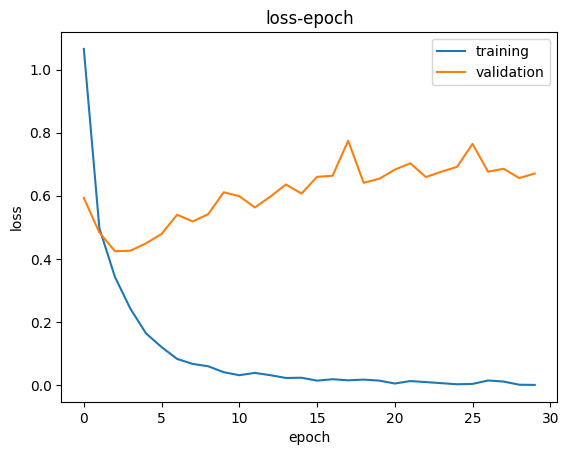

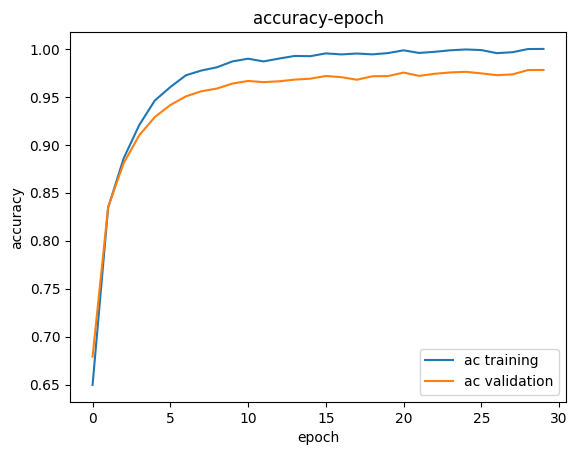

In [4]:
# 1. torchvision을 사용하여 CIFAR10을 불러오고 정규화 하기
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import f1_score

def compute_f1score(model, testloader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

# Compose(), 여러 변환 작업을 단일 파이프라인으로 연결
transform = transforms.Compose(
    # ToTensor(), Python Image Library or Numpy 배열인 입력 이미지를 파이토치 텐서로 변환
    [transforms.ToTensor(),
     # 평균 및 표준 편차로 tensor 정규화, 각 채널의 평균값(RGB), 각 채널의 표준편차 값 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# 각 미니 배치에 32개의 샘플이 포함됨
batch_size = 32

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        # transforms.Compose()를 사용하여 이전에 정의된 변환 파이프라인으로 설정
                                        download=True, transform=transform)


# train_ds : val_ds = 8 : 2 로 dataset을 split
torch.manual_seed(43)
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

# num_workers : 데이터 로드에 사용할 하위 프로세스 수
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

validationloader = DataLoader(val_ds, batch_size=batch_size*2, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

## loss function의 train_loss 와 validation_loss
loss_train = []
loss_validation = []

## train & validation accuracy 
train_acc_list = []
val_acc_list = []

# 2. torchvision.models로 vgg16 불러오기
model = torchvision.models.vgg16(pretrained=True)


## CUDA 기기가 존재한다면, CUDA 장치를 출력:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)


# 3. 손실 함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)


# 4. 학습용 데이터를 사용하여 신경망 학습
n = len(trainloader)
m = len(validationloader)

for epoch in range(30):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training Phase
    for i, data in enumerate(trainloader, 0):
        # training mode
        model.train()

        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # inputs, labels = data # cuda 사용
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력
        running_loss += loss.item()

        # training accuracy 계산
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        if i % n == n-1:
            print(f'Training : [{epoch + 1}, {i + 1:5d}] loss: {running_loss / n:.3f} accuracy: {correct_predictions / total_predictions:.3f}')
            loss_train.append(running_loss / n)
            train_acc_list.append(correct_predictions / total_predictions)
            running_loss = 0.0
    
    with torch.no_grad():
        # evaluation mode
        model.eval()
        
        # Validation Phase
        for i, data in enumerate(validationloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            # optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # validation accuracy 계산
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # 통계를 출력
            running_loss += loss.item()
            if i % m == m-1:
                print(f'Validation : [{epoch + 1}, {i + 1:5d}] loss: {running_loss / m:.3f} accuracy: {correct_predictions / total_predictions:.3f}')
                loss_validation.append(running_loss / m)
                # validation data 정확도 기록하는 부분
                val_acc_list.append(correct_predictions / total_predictions)
                running_loss = 0.0




print('Finished Training\n')


# 5.1 loss - epoch 그래프 출력
plt.figure(1)
plt.title("loss-epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_train, label = 'training')
plt.plot(loss_validation, label = 'validation')
plt.legend()

# 5.2 accuracy - epoch 그래프 출력
plt.figure(2)
plt.title("accuracy-epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(train_acc_list, label = 'ac training')
plt.plot(val_acc_list, label = 'ac validation')
plt.legend()


# 학습한 모델 저장
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도 필요 없음
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


# 6.F1 score 출력
test_f1 = compute_f1score(model, testloader, device)
print('\nTest F1 score: {:.4f}'.format(test_f1))